Важной характеристикой алгоритма машинного обучения является его обобщающая способность — способность использовать знания, полученные при обучении, на новых данных.

**Переобучение (overfitting)** — это проблема, при которой модель чувствительна к незначительным колебаниям в данных в процессе обучения. По сути, такая модель работает намного лучше с обучающими данными, чем с новыми. Она была чрезмерно натренирована на обнаружение уникальных характеристик обучающего набора данных, которые не являются общими закономерностями.

**Недообучение (underfitting)** — это проблема, при которой алгоритм недостаточно хорошо изучил данные и пропускает важные зависимости между признаками. В случае недообучения мы даже на обучающих данных не можем достичь приемлемых оценок для модели.

**Смещение (bias)** — это математическое ожидание (обозначено далее как $E$) разности между истинным ответом и ответом, выданным моделью. То есть это ожидаемая ошибка модели.

Bias — это теоретическая характеристика недообучения.

**Разброс (variance)** — это вариативность ошибки, то, насколько ошибка будет отличаться, если обучать модель на разных наборах данных. Математически это дисперсия (разброс) ответов модели (обозначено далее как $Var$).

Variance — это теоретическая характеристика переобучения.

Еще есть в курсе

В случае задачи регрессии underfitting и overfitting можно проиллюстрировать следующим образом:

![alt](https://lms.skillfactory.ru/assets/courseware/v1/b5e179a6024a680d4dfa71c99f2c73d7/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst3-ml5-4_1.png)

Underfitting и overfitting в случае задачи классификации:

![alt](https://lms.skillfactory.ru/assets/courseware/v1/0ef73dfeeb026fbfb18138037c64e77f/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst3-ml5-4_2.png)

### <center> КАК ОБНАРУЖИТЬ ПЕРЕОБУЧЕНИЕ

Основные способы отследить переобучение:

hold-out-разбиение,

k-fold-валидация и leave-one-out-валидация,

кривые обучения (learning curves)

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

In [2]:
water_data = pd.read_csv('data/water_potability.csv')
#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

In [3]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

In [4]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model_bad = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    class_weight='balanced', #веса классов
    random_state=42 #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model_bad.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model_bad.predict(X_train)
y_valid_pred = model_bad.predict(X_valid)
#Выводим значения метрик для тренировочной выборки
print('Train F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
#Выводим значения метрик для валидационной выборки
print('Valid F1 score: {:.2f}'.format(metrics.f1_score(y_valid, y_valid_pred)))
 
# Train F1 score: 1.00
# Valid F1 score: 0.67

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=42)

Train F1 score: 1.00
Valid F1 score: 0.67


Проверим гипотезу о наличии переобучения у нашего дерева с помощью кросс-валидации k-fold. Организуем стратифицированную кросс-валидацию на пяти фолдах. На каждом шаге кросс-валидации будем вычислять метрику $F_{1}$ на тренировочных и валидационных фолдах.

In [5]:
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model_bad, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.02910519, 0.02719831, 0.03105664, 0.02701735, 0.02864885]),
 'score_time': array([0.00191569, 0.00200033, 0.00134754, 0.00200057, 0.00199461]),
 'test_score': array([0.61445783, 0.68421053, 0.62332696, 0.63276836, 0.70119522]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [6]:
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.65


<AxesSubplot:xlabel='feature_1', ylabel='feature_2'>

Train accuracy: 0.98
Valid accuracy: 0.82


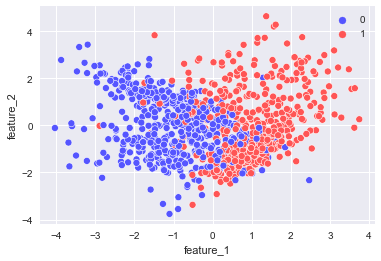

In [7]:
# Задание 4.3

from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y, palette='seismic');
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)
model_forest = tree.DecisionTreeClassifier(
    max_depth=10
)
model_forest = model_forest.fit(X_train, y_train)
predict_train = model_forest.predict(X_train)
predict_valid = model_forest.predict(X_valid)
print('Train accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, predict_train)))
print('Valid accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, predict_valid)))


In [13]:
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

c:\Users\d3en\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\d3en\AppData\Local\Temp\ipykernel_13112\4088893635.py:23: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = fig.colorbar(contour)


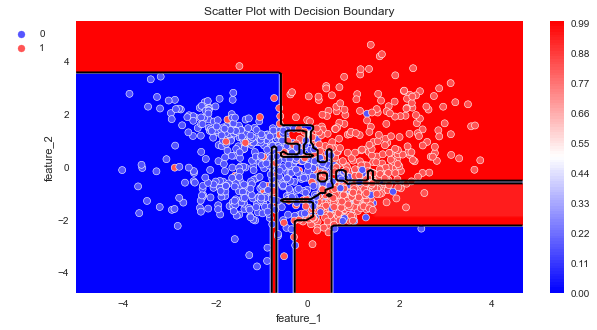

In [10]:
plot_probabilities_2d(X, y, model_forest)

### <center> МЕТОДЫ БОРЬБЫ С ПЕРЕОБУЧЕНИЕМ

Все в курсе

In [12]:
# Для начала посмотрим на текущую глубину дерева:

print('Current depth:', model_bad.get_depth())

Current depth: 27


In [4]:
# Повтор разбиения!, что бы код снизу коректно работал как в курсе
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [9]:
#Пересоздаем предыдующуу модель( Значения Х y меняются, если запустить код сразу с начала)
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.75
Valid k-fold mean f1: 0.66


Напомним интерпретацию данного параметра. Пусть **min_samples_leaf=5**. Допустим, в результате разделения получается две вершины: первая — с четырьмя объектами, а вторая — с шестью. Тогда дерево разрешит снова делиться только второй вершине (6 > min_samples_leaf), а первая вершина (4 < min_samples_leaf) дерева превратится в лист, и её деление будет остановлено.

In [10]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    min_samples_leaf=5, #увеличиваем количество объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
## Train k-fold mean f1: 0.74
## Valid k-fold mean f1: 0.66

Train k-fold mean f1: 0.74
Valid k-fold mean f1: 0.66


Нам удалось ещё немного сократить разницу между метриками на тренировочных и валидационных фолдах и уменьшить переобучение.

<AxesSubplot:xlabel='feature_1', ylabel='feature_2'>

Train accuracy: 0.88
Valid accuracy: 0.85


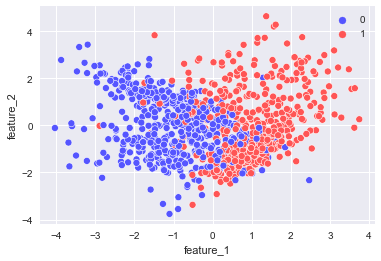

In [11]:
# Задание 4.6

from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y, palette='seismic');
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)
model_forest = tree.DecisionTreeClassifier(
    max_depth=3
)
model_forest = model_forest.fit(X_train, y_train)
predict_train = model_forest.predict(X_train)
predict_valid = model_forest.predict(X_valid)
print('Train accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, predict_train)))
print('Valid accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, predict_valid)))


c:\Users\d3en\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\d3en\AppData\Local\Temp\ipykernel_10760\4088893635.py:23: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = fig.colorbar(contour)


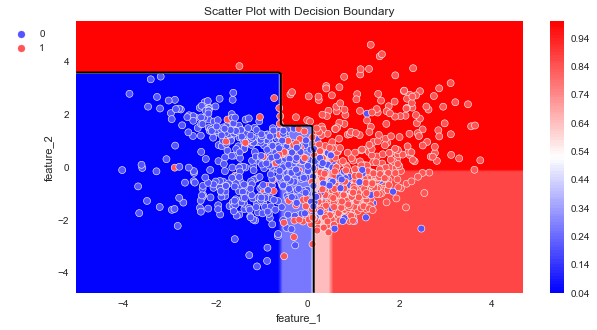

In [14]:
plot_probabilities_2d(X, y, model_forest)

### <center>  УТЕЧКА ДАННЫХ 

Утечка данных (data leak) — это ситуация, в которой данные, используемые для обучения модели, содержат прямую или косвенную информацию о целевой переменной.

### КАК ОБНАРУЖИТЬ УТЕЧКУ ДАННЫХ

Остальное в курсе